In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navjotkaushal/human-vs-ai-generated-essays")

print("Path to dataset files:", path)

100%|██████████| 1.40M/1.40M [00:00<00:00, 47.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/navjotkaushal/human-vs-ai-generated-essays/versions/1


In [171]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 63.2 MB/s eta 0:00:00


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0aa3aeda939b68244f0226ecc09845b8655f07eaa6c1374d49799e71fa670617
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 11.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import spacy
nlp = spacy.load("en_core_web_sm")
import re
import emoji
from collections import Counter
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
import joblib
import shap
from lime.lime_text import LimeTextExplainer
from tqdm import tqdm
import math
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sklearn.decomposition import TruncatedSVD

In [98]:
df = pd.read_csv(f"{path}/balanced_ai_human_prompts.csv")

In [99]:
df.head()

,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


In [100]:
df['generated'].value_counts()


,count
generated,
1,1375
0,1375


In [101]:
df.isnull().sum()

,0
text,0
generated,0


In [102]:
# def break_into_sentence(text : str):
#     doc = nlp(text)
#     return [sent.text for sent in doc.sents]

In [103]:
# print(break_into_sentence(df['text'][0]))

In [104]:
df.rename(columns={'text': 'content', 'generated': 'label'}, inplace=True)

In [105]:
train_df = df.copy()

In [106]:
# rows = []

# for row in df.itertuples():
#     for sent in break_into_sentence(row.text):
#         rows.append({'sentence': sent.lower(), 'label': row.generated})

# train_df = pd.DataFrame(rows)


In [107]:
train_df.head()

,content,label
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


In [108]:
train_df['label'].value_counts()

,count
label,
1,1375
0,1375


In [109]:
def clean_text(text: str) -> str:
    """
    Cleans the text for essay classification while preserving punctuation.
    Removes:
    - URLs
    - Emojis
    - Mentions (@user)
    - Hashtags (#tag)
    - Extra whitespace
    Keeps all punctuation intact.
    """
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [110]:
train_df['content'] = train_df['content'].apply(clean_text)


# punct_ratio:

*    Ratio of punctuation marks to total characters — captures how expressive or "structured" writing is.
*   AI text often has more uniform, balanced punctuation; human text can vary more.

# avg_token_length:

*   Average token length — longer tokens may indicate more complex vocabulary usage.
*    Humans tend to use more varied and occasionally longer words than AI models.

# type_token_ratio:

*   Type-Token Ratio (unique_words / total_words) — measures vocabulary diversity.
*   Lower ratios suggest repetitive or formulaic writing (common in AI text).

# hapax_legomena_ratio

*   Hapax Legomena Ratio — proportion of words that appear only once.
*   Higher ratios indicate richer, more varied vocabulary (typical of human writing).







In [111]:
SELECTED_POS = {
    "NOUN": "pos_noun_ratio",
    "PUNCT": "pos_punct_ratio",
    "DET": "pos_det_ratio",
    "ADJ": "pos_adj_ratio",
    "ADV": "pos_adv_ratio",
    "VERB": "pos_verb_ratio",
    "PRON": "pos_pron_ratio"
}

def extract_text_features(text: str):
    doc = nlp(text)
    words = [token.text for token in doc if token.is_alpha]  # only real words
    num_words = len(words)
    unique_words = len(set(words))

    # Avoid division-by-zero
    denom = max(1, num_words)

    # --- POS ratios (all normalized by word count) ---
    pos_counts = {v: 0 for v in SELECTED_POS.values()}
    for token in doc:
        if token.pos_ in SELECTED_POS:
            pos_counts[SELECTED_POS[token.pos_]] += 1

    for k in pos_counts:
        pos_counts[k] /= denom

    # --- Punctuation normalized by word count ---
    punct_count = sum(token.pos_ == "PUNCT" for token in doc)
    punct_ratio = punct_count / denom

    # --- Other length-normalized features ---
    base_features = {
        "punct_ratio": punct_ratio,
        "avg_token_length": np.mean([len(w) for w in words]) if words else 0,
        "type_token_ratio": unique_words / denom,
        "hapax_legomena_ratio": sum(1 for w in set(words) if words.count(w) == 1) / denom
    }

    return {**base_features, **pos_counts}


In [112]:
features_list = [extract_text_features(text) for text in train_df["content"]]
features_df = pd.DataFrame(features_list)
train_df = pd.concat([train_df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)
train_df.head()


,content,label,punct_ratio,avg_token_length,type_token_ratio,hapax_legomena_ratio,pos_noun_ratio,pos_punct_ratio,pos_det_ratio,pos_adj_ratio,pos_adv_ratio,pos_verb_ratio,pos_pron_ratio
0,"Machine learning, a subset of artificial intel...",1,0.166667,6.364583,0.770833,0.677083,0.406250,0.166667,0.072917,0.083333,0.020833,0.135417,0.020833
1,"A decision tree, a prominent machine learning ...",1,0.180952,6.219048,0.790476,0.666667,0.390476,0.180952,0.104762,0.104762,0.009524,0.161905,0.000000
2,"Education, a cornerstone of societal progress,...",1,0.242105,6.757895,0.821053,0.715789,0.347368,0.242105,0.063158,0.178947,0.031579,0.189474,0.021053
3,"Computers, the backbone of modern technology, ...",1,0.217391,6.597826,0.793478,0.695652,0.445652,0.217391,0.054348,0.130435,0.010870,0.086957,0.010870
4,"Chess, a timeless game of strategy and intelle...",1,0.189189,6.225225,0.747748,0.630631,0.396396,0.189189,0.090090,0.117117,0.027027,0.135135,0.009009


In [113]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   content               2750 non-null   object 
 1   label                 2750 non-null   int64  
 2   punct_ratio           2750 non-null   float64
 3   avg_token_length      2750 non-null   float64
 4   type_token_ratio      2750 non-null   float64
 5   hapax_legomena_ratio  2750 non-null   float64
 6   pos_noun_ratio        2750 non-null   float64
 7   pos_punct_ratio       2750 non-null   float64
 8   pos_det_ratio         2750 non-null   float64
 9   pos_adj_ratio         2750 non-null   float64
 10  pos_adv_ratio         2750 non-null   float64
 11  pos_verb_ratio        2750 non-null   float64
 12  pos_pron_ratio        2750 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 279.4+ KB


In [114]:
train_df.fillna(0, inplace=True)


In [115]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   content               2750 non-null   object 
 1   label                 2750 non-null   int64  
 2   punct_ratio           2750 non-null   float64
 3   avg_token_length      2750 non-null   float64
 4   type_token_ratio      2750 non-null   float64
 5   hapax_legomena_ratio  2750 non-null   float64
 6   pos_noun_ratio        2750 non-null   float64
 7   pos_punct_ratio       2750 non-null   float64
 8   pos_det_ratio         2750 non-null   float64
 9   pos_adj_ratio         2750 non-null   float64
 10  pos_adv_ratio         2750 non-null   float64
 11  pos_verb_ratio        2750 non-null   float64
 12  pos_pron_ratio        2750 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 279.4+ KB


* token_entropy measures the unpredictability or randomness of each token in a text.
* Higher entropy means more diverse word choices, while lower entropy indicates repetitive or predictable text.
* In AI vs. human essay detection, token_entropy helps because AI-generated text often has lower entropy (more predictable word patterns), whereas human writing tends to have higher entropy due to varied vocabulary and sentence structures.


In [116]:
def token_entropy(words):
    freq = Counter(words)
    probs = [v / len(words) for v in freq.values()]
    return -sum(p * log2(p) for p in probs)


In [117]:
def normalized_token_entropy(words):
    n = len(words)
    if n <= 1:
        return 0.0
    freq = Counter(words)
    probs = [v / n for v in freq.values()]
    H = -sum(p * log2(p) for p in probs)
    return H / log2(n)

In [118]:
def calculate_sentence_token_entropy(sentence : str):
  doc = nlp(sentence)
  words = [token.text for token in doc]

  return normalized_token_entropy(words)

In [119]:
for row in train_df.itertuples():
    train_df.at[row.Index, 'sentence_token_entropy'] = calculate_sentence_token_entropy(row.content)

In [120]:
train_df.head()

,content,label,punct_ratio,avg_token_length,type_token_ratio,hapax_legomena_ratio,pos_noun_ratio,pos_punct_ratio,pos_det_ratio,pos_adj_ratio,pos_adv_ratio,pos_verb_ratio,pos_pron_ratio,sentence_token_entropy
0,"Machine learning, a subset of artificial intel...",1,0.166667,6.364583,0.770833,0.677083,0.406250,0.166667,0.072917,0.083333,0.020833,0.135417,0.020833,0.856662
1,"A decision tree, a prominent machine learning ...",1,0.180952,6.219048,0.790476,0.666667,0.390476,0.180952,0.104762,0.104762,0.009524,0.161905,0.000000,0.871982
2,"Education, a cornerstone of societal progress,...",1,0.242105,6.757895,0.821053,0.715789,0.347368,0.242105,0.063158,0.178947,0.031579,0.189474,0.021053,0.853003
3,"Computers, the backbone of modern technology, ...",1,0.217391,6.597826,0.793478,0.695652,0.445652,0.217391,0.054348,0.130435,0.010870,0.086957,0.010870,0.843136
4,"Chess, a timeless game of strategy and intelle...",1,0.189189,6.225225,0.747748,0.630631,0.396396,0.189189,0.090090,0.117117,0.027027,0.135135,0.009009,0.849277


In [121]:
# !nvidia-smi


In [122]:
# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [123]:
# model_name = "gpt2"  # changed from "gpt2-large" to "gpt2" due to GPU limitations
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)
# model = GPT2LMHeadModel.from_pretrained(model_name)
# model.eval()
# if torch.cuda.is_available():
#     model.to("cuda")

In [124]:
# MAX_TOKENS = 1024
# LENGTH_THRESHOLD = 1500  # essays longer than this will be chunked

# def compute_perplexity_ids(input_ids):
#     """
#     input_ids: list[int] (already token IDs, not strings)
#     """
#     # Truncate to MAX_TOKENS just in case
#     ids = input_ids[:MAX_TOKENS]

#     # Make tensor of shape (1, seq_len)
#     input_ids_tensor = torch.tensor([ids], dtype=torch.long)

#     # Safety clamp (shouldn't be needed, but avoids rare edge cases)
#     vocab_size = model.config.vocab_size
#     input_ids_tensor = torch.clamp(input_ids_tensor, 0, vocab_size - 1)

#     if torch.cuda.is_available():
#         input_ids_tensor = input_ids_tensor.to("cuda")

#     with torch.no_grad():
#         outputs = model(input_ids=input_ids_tensor, labels=input_ids_tensor)
#         loss = outputs.loss.item()

#     return math.exp(loss)

In [125]:
# def hybrid_perplexity(text: str):
#     # Encode ONCE → token IDs
#     input_ids = tokenizer.encode(text, add_special_tokens=False)
#     n_tokens = len(input_ids)

#     # Short / medium texts → single chunk
#     if n_tokens <= MAX_TOKENS or n_tokens <= LENGTH_THRESHOLD:
#         return compute_perplexity_ids(input_ids)

#     # Long texts → split into MAX_TOKENS chunks
#     chunk_ppls = []
#     for i in range(0, n_tokens, MAX_TOKENS):
#         chunk_ids = input_ids[i:i + MAX_TOKENS]
#         if len(chunk_ids) == 0:
#             continue
#         chunk_ppls.append(compute_perplexity_ids(chunk_ids))

#     if not chunk_ppls:
#         return None

#     return sum(chunk_ppls) / len(chunk_ppls)

In [126]:
# train_df["n_tokens"] = train_df["content"].apply(
#     lambda x: len(tokenizer.encode(x, add_special_tokens=False))
# )


In [127]:
train_df['label'].value_counts()

,count
label,
1,1375
0,1375


In [128]:
# filtered = train_df[train_df['n_tokens'] <= 50]
# label_counts = filtered.groupby('label').count()['n_tokens']
# print(label_counts)


In [129]:
# MIN_TOKENS = 50
# train_df = train_df[train_df['n_tokens'] >= MIN_TOKENS].reset_index(drop=True)

In [130]:
# perplexities = []
# for text in tqdm(train_df["content"]):
#     try:
#         ppl = hybrid_perplexity(text)
#     except Exception as e:
#         ppl = None
#         print("Error on text:", str(text)[:80], "|", e)
#     perplexities.append(ppl)

# train_df["perplexity"] = perplexities

In [131]:
X = train_df.drop(columns=['label'])
y = train_df['label']

In [132]:
y.value_counts()

,count
label,
1,1375
0,1375


In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [134]:
X_train.head()

,content,punct_ratio,avg_token_length,type_token_ratio,hapax_legomena_ratio,pos_noun_ratio,pos_punct_ratio,pos_det_ratio,pos_adj_ratio,pos_adv_ratio,pos_verb_ratio,pos_pron_ratio,sentence_token_entropy
66,"""Plastic water bottles, a ubiquitous sight in ...",0.152597,5.733766,0.581169,0.415584,0.321429,0.152597,0.081169,0.152597,0.038961,0.120130,0.042208,0.812785
1136,"Countries like France, Columbia, Germany and U...",0.103659,4.756098,0.573171,0.375000,0.283537,0.103659,0.091463,0.073171,0.036585,0.134146,0.045732,0.835505
1448,An electoral College compromises between elect...,0.075294,4.654118,0.505882,0.343529,0.195294,0.075294,0.103529,0.087059,0.030588,0.129412,0.082353,0.805984
25,The Evolution of Fashion: From Function to Exp...,0.184211,5.710526,0.842105,0.710526,0.263158,0.184211,0.105263,0.131579,0.026316,0.078947,0.000000,0.921056
2434,Draft a technical report analyzing artificial ...,0.071429,6.214286,1.000000,1.000000,0.357143,0.071429,0.142857,0.214286,0.000000,0.142857,0.000000,1.000000


In [135]:
X_train_without_tfidf = X_train.copy()
X_train_without_tfidf.drop(columns=['content'], inplace=True)

X_test_without_tfidf = X_test.copy()
X_test_without_tfidf.drop(columns=['content'], inplace=True)



# TF-IDF (Term Frequency-Inverse Document Frequency) converts text into numerical features that reflect how important each word or phrase is within a document compared to the whole corpus.
# It helps in AI vs. human essay detection because humans tend to use more varied and context-specific vocabulary, while AI-generated text often repeats common patterns. TF-IDF highlights these differences, making it easier for a model to distinguish between AI and human writing.


In [136]:
tfidf = TfidfVectorizer(
    max_features=3000,
    stop_words='english',
    ngram_range=(1, 3)
)


In [152]:
X_train_tfidf = tfidf.fit_transform(X_train['content'])
X_test_tfidf = tfidf.transform(X_test['content'])

In [157]:
n_components = 75  # you can tune this

svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit SVD on the training TF-IDF matrix and transform it
X_train_svd = svd.fit_transform(X_train_tfidf)

# Transform the test TF-IDF matrix
X_test_svd = svd.transform(X_test_tfidf)

# Optional: check explained variance
print("Explained variance ratio (sum):", svd.explained_variance_ratio_.sum())

Explained variance ratio (sum): 0.7083629449368577


In [163]:
X_train_num = X_train.drop(columns=['content','pos_noun_ratio','pos_det_ratio'])
X_test_num = X_test.drop(columns=['content','pos_noun_ratio','pos_det_ratio'])


In [164]:
# Combine TF-IDF + numeric features
X_train_final = np.hstack([X_train_svd, X_train_num])
X_test_final = np.hstack([X_test_svd, X_test_num])

In [165]:
print("Train shape:", X_train_final.shape)
print("Test shape:", X_test_final.shape)


Train shape: (2200, 85)
Test shape: (550, 85)


In [141]:
# results = XGBoost.evals_result()
# train_acc = [1 - x for x in results['validation_0']['error']]
# test_acc = [1 - x for x in results['validation_1']['error']]


In [142]:
def xgb_hyperparam_scan(X_train, y_train, X_test, y_test, max_depth_list, n_estimators_list, random_state=42):
    """
    Trains XGBoost on all combinations of max_depth and n_estimators,
    and returns a dict of train/test accuracy curves.

    Parameters:
        X_train, y_train, X_test, y_test : arrays / dataframes
        max_depth_list : list of max_depth values
        n_estimators_list : list of n_estimators values
        random_state : int

    Returns:
        results_dict : dict with keys like (max_depth, n_estimators) and values:
                       {'train_acc': [...], 'test_acc': [...]}
    """
    results_dict = {}

    for depth in max_depth_list:
        for n_est in n_estimators_list:
            # Initialize model
            model = XGBClassifier(
                max_depth=depth,
                n_estimators=n_est,
                random_state=random_state,
                eval_metric='error'
            )

            # Fit with eval_set
            eval_set = [(X_train, y_train), (X_test, y_test)]
            model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

            # Get train/test accuracy curves
            evals_result = model.evals_result()
            train_acc = [1 - x for x in evals_result['validation_0']['error']]
            test_acc = [1 - x for x in evals_result['validation_1']['error']]

            # Store results
            results_dict[(depth, n_est)] = {'train_acc': train_acc, 'test_acc': test_acc, 'model' : model}

    return results_dict

In [143]:
max_depths = [2, 3, 4]
n_estimators = [10,20, 30, 50]

In [166]:
results = xgb_hyperparam_scan(
    X_train_final, y_train,
    X_test_final, y_test,
    max_depth_list=max_depths,
    n_estimators_list=n_estimators
)

best_params = None
best_test_acc = -float('inf')

for params, metrics in results.items():
    final_test_acc = metrics['test_acc'][-1]  # take the last epoch/iteration accuracy
    if final_test_acc > best_test_acc:
        best_test_acc = final_test_acc
        best_params = params

print("Best hyperparameters:", best_params)
print("Best test accuracy:", best_test_acc)
print("Train accuracy curve for best params:", results[best_params]['train_acc'])
print("Test accuracy curve for best params:", results[best_params]['test_acc'])

Best hyperparameters: (2, 10)
Best test accuracy: 0.9981818181818182
Train accuracy curve for best params: [0.9990909090909091, 0.9990909090909091, 0.9990909090909091, 0.9990909090909091, 0.9990909090909091, 0.9990909090909091, 0.9990909090909091, 0.9990909090909091, 0.9990909090909091, 0.9995454545454545]
Test accuracy curve for best params: [0.9981818181818182, 0.9981818181818182, 0.9981818181818182, 0.9981818181818182, 0.9981818181818182, 0.9981818181818182, 0.9981818181818182, 0.9981818181818182, 0.9981818181818182, 0.9981818181818182]


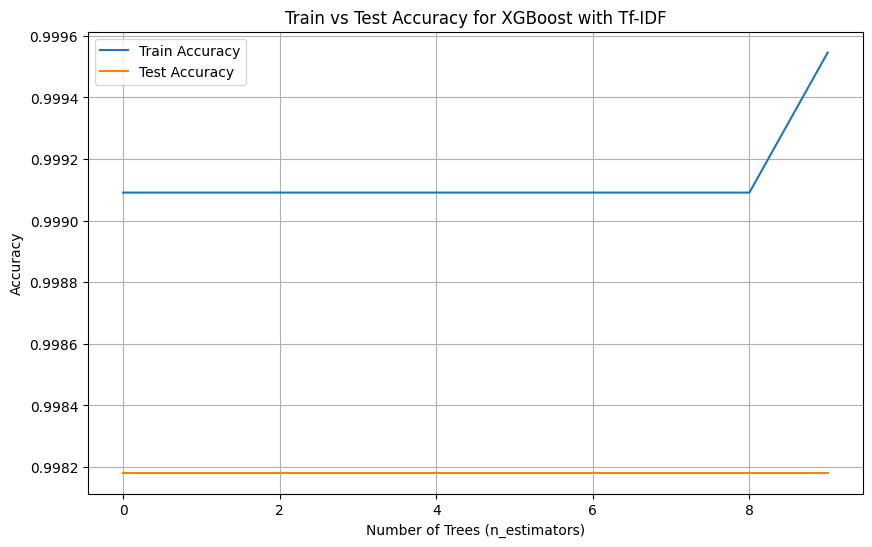

In [177]:
plt.figure(figsize=(10,6))
plt.plot(results[best_params]['train_acc'], label='Train Accuracy')
plt.plot(results[best_params]['test_acc'], label='Test Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for XGBoost with Tf-IDF')
plt.legend()
plt.grid(True)
plt.show()


In [146]:
results_without_tdidf = xgb_hyperparam_scan(
    X_train_without_tfidf, y_train,
    X_test_without_tfidf, y_test,
    max_depth_list=max_depths,
    n_estimators_list=n_estimators
)



In [147]:
best_params = None
best_test_acc = -float('inf')

for params, metrics in results_without_tdidf.items():
    final_test_acc = metrics['test_acc'][-1]  # take the last epoch/iteration accuracy
    if final_test_acc > best_test_acc:
        best_test_acc = final_test_acc
        best_params = params

print("Best hyperparameters:", best_params)
print("Best test accuracy:", best_test_acc)
print("Train accuracy curve for best params:", results_without_tdidf[best_params]['train_acc'])
print("Test accuracy curve for best params:", results_without_tdidf[best_params]['test_acc'])

Best hyperparameters: (2, 30)
Best test accuracy: 0.9981818181818182
Train accuracy curve for best params: [0.995, 0.9959090909090909, 0.9959090909090909, 0.9963636363636363, 0.9963636363636363, 0.9963636363636363, 0.9972727272727273, 0.9977272727272727, 0.9977272727272727, 0.9977272727272727, 0.9977272727272727, 0.9981818181818182, 0.9981818181818182, 0.9986363636363637, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545, 0.9995454545454545]
Test accuracy curve for best params: [0.9981818181818182, 0.9963636363636363, 0.9963636363636363, 0.9981818181818182, 0.9963636363636363, 0.9981818181818182, 0.9963636363636363, 0.9963636363636363, 0.9945454545454545, 0.9945454545454545, 0.9963636363636363, 0.9963636363636363, 0.9963636363636363, 0.99636

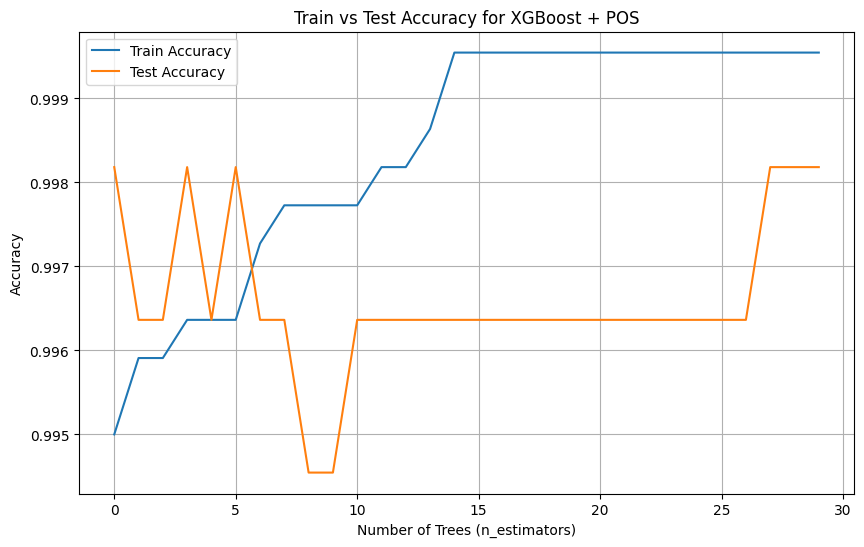

In [148]:
plt.figure(figsize=(10,6))
plt.plot(results_without_tdidf[best_params]['train_acc'], label='Train Accuracy')
plt.plot(results_without_tdidf[best_params]['test_acc'], label='Test Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for XGBoost + POS')
plt.legend()
plt.grid(True)
plt.show()


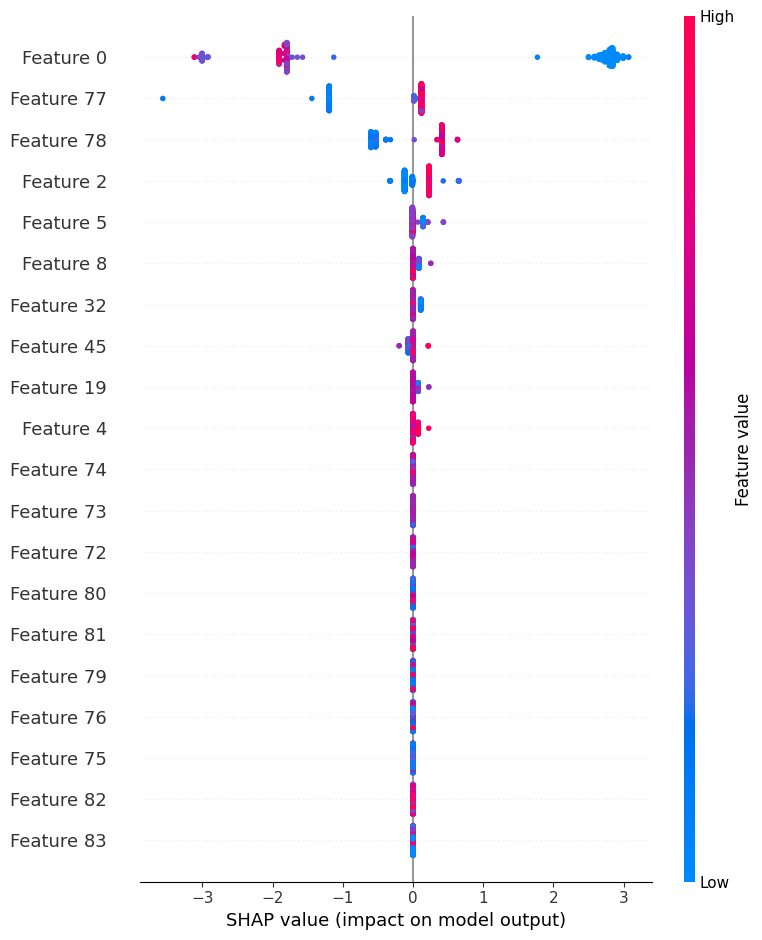

In [168]:
explainer = shap.Explainer(results[best_params]['model'])
shap_values = explainer(X_test_final)  # X_test_final should be same features as used in training

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test_final, max_display=20)

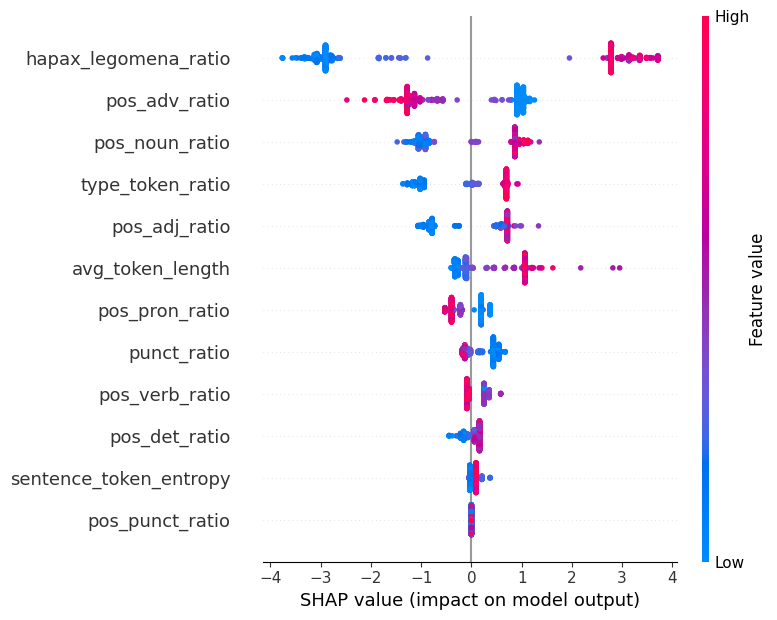

In [149]:
explainer = shap.Explainer(results_without_tdidf[best_params]['model'])
shap_values = explainer(X_test_without_tfidf)  # X_test_final should be same features as used in training

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test_without_tfidf, max_display=20)

In [173]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

nltk.download('punkt_tab')

# ==========================
# 1. Tokenize essays
# ==========================
def tokenize_docs(docs):
    return [word_tokenize(doc.lower()) for doc in docs]

train_sentences = tokenize_docs(X_train['content'])
test_sentences  = tokenize_docs(X_test['content'])

# ==========================
# 2. Train Word2Vec
# ==========================
w2v_model = Word2Vec(
    sentences=train_sentences,
    vector_size=100,  # can tune
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

word_vectors = w2v_model.wv

# ==========================
# 3. Convert essays to vectors (average word embeddings)
# ==========================
def document_vector(tokens):
    tokens = [w for w in tokens if w in word_vectors.key_to_index]
    if len(tokens) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(word_vectors[tokens], axis=0)

X_train_w2v = np.array([document_vector(doc) for doc in train_sentences])
X_test_w2v  = np.array([document_vector(doc) for doc in test_sentences])

# ==========================
# 4. Combine with numeric features
# ==========================
# Standardize numeric features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled  = scaler.transform(X_test_num)

# Combine dense vectors
X_train_combined = np.hstack([X_train_w2v, X_train_num_scaled])
X_test_combined  = np.hstack([X_test_w2v, X_test_num_scaled])

results_word2vec = xgb_hyperparam_scan(
    X_train_combined, y_train,
    X_test_combined, y_test,
    max_depth_list=max_depths,
    n_estimators_list=n_estimators
)

best_params = None
best_test_acc = -float('inf')

for params, metrics in results_word2vec.items():
    final_test_acc = metrics['test_acc'][-1]  # take the last epoch/iteration accuracy
    if final_test_acc > best_test_acc:
        best_test_acc = final_test_acc
        best_params = params


model = results_word2vec[best_params]['model']

# ==========================
y_pred = model.predict(X_test_combined)
y_proba = model.predict_proba(X_test_combined)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Accuracy: 0.9981818181818182
ROC-AUC: 0.9981289256198348


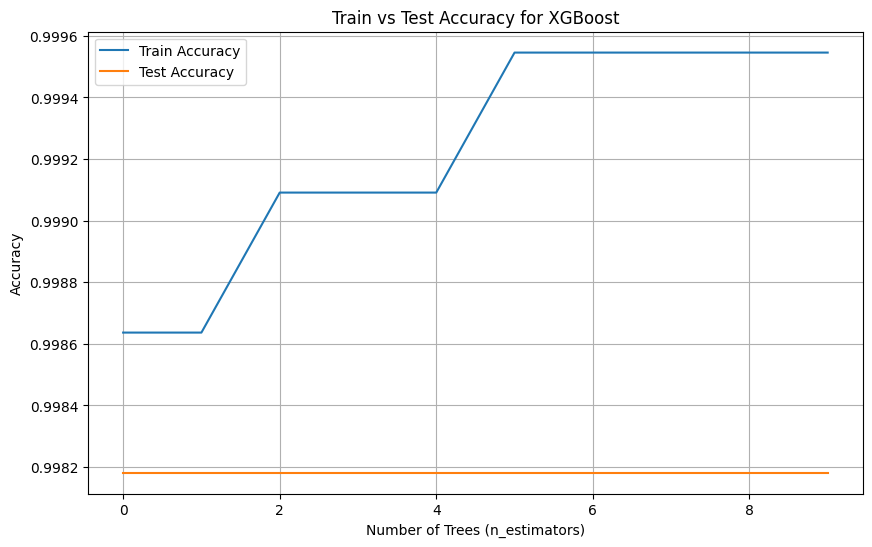

In [174]:
plt.figure(figsize=(10,6))
plt.plot(results_word2vec[best_params]['train_acc'], label='Train Accuracy')
plt.plot(results_word2vec[best_params]['test_acc'], label='Test Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for XGBoost')
plt.legend()
plt.grid(True)
plt.show()


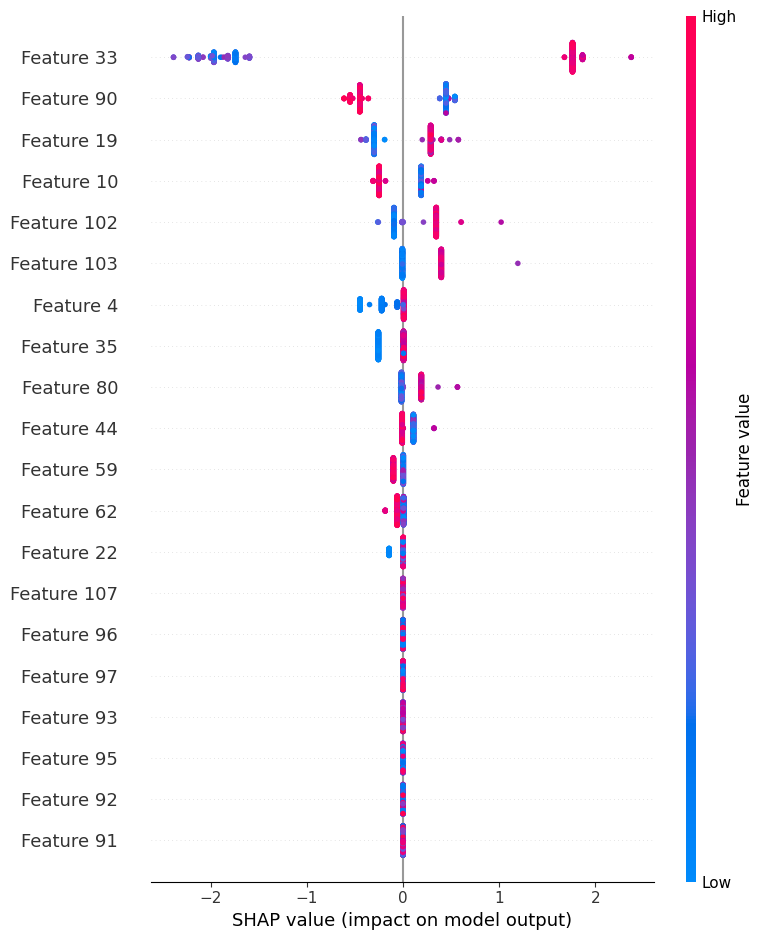

In [176]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test_combined)  # X_test_final should be same features as used in training

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test_combined, max_display=20)

In [178]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_test, pos_label=1):
    """
    Evaluate a classification model: ROC-AUC, classification report, confusion matrix.

    Args:
        model: trained scikit-learn compatible model
        X_test: test features
        y_test: test labels
        pos_label: label considered "positive" for ROC-AUC
    """
    # ---------- Predictions ----------
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # fallback for models that output decision function
        y_proba = model.decision_function(X_test)

    # ---------- ROC-AUC ----------
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=pos_label)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curve")
    plt.legend()
    plt.show()

    # ---------- Classification report ----------
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # ---------- Confusion matrix ----------
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return roc_auc, y_pred, y_proba

# --------------------------
# Example usage:
# --------------------------
# model = XGBClassifier(...) or LogisticRegression(...) etc.
# model.fit(X_train_scaled, y_train)
# evaluate_model(model, X_test_scaled, y_test)


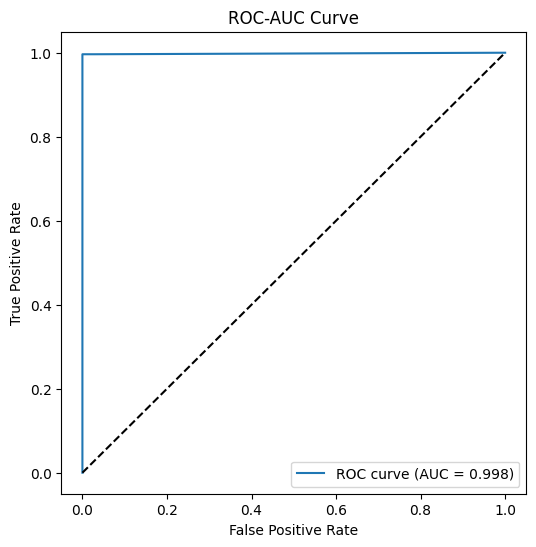

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      1.00      1.00       275

    accuracy                           1.00       550
   macro avg       1.00      1.00      1.00       550
weighted avg       1.00      1.00      1.00       550



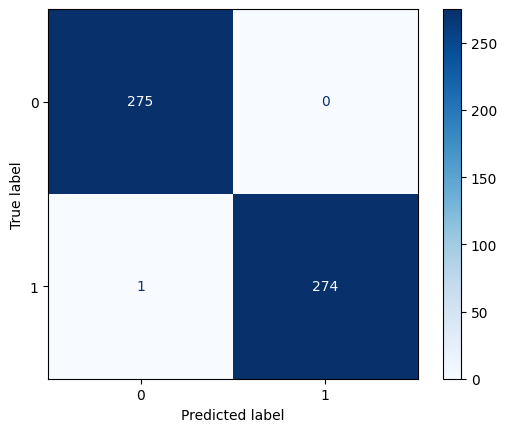

(np.float64(0.9981289256198348),
 array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
     

In [179]:
evaluate_model(model, X_test_combined, y_test)

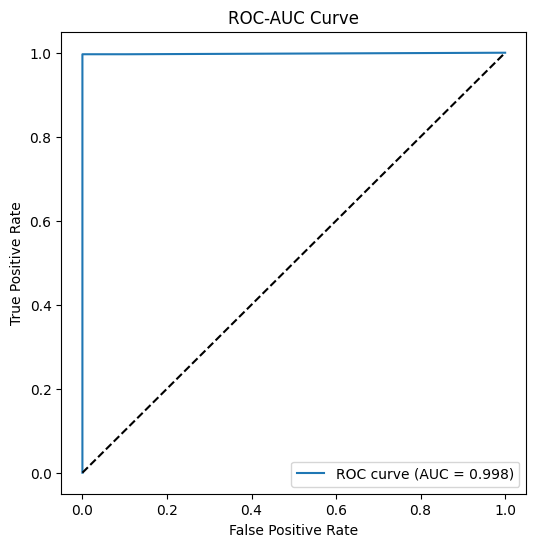

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       275
           1       1.00      0.99      0.99       275

    accuracy                           0.99       550
   macro avg       0.99      0.99      0.99       550
weighted avg       0.99      0.99      0.99       550



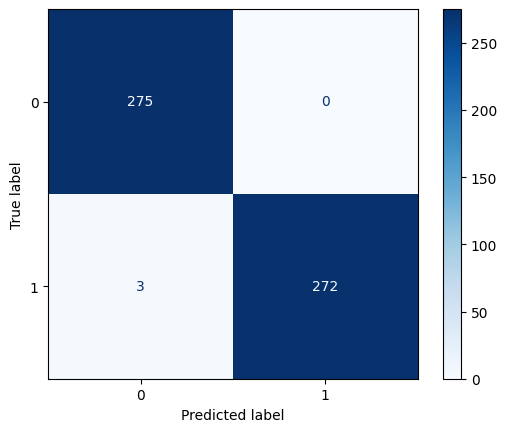

(np.float64(0.9979900826446281),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
     

In [180]:
evaluate_model(results_without_tdidf[best_params]['model'], X_test_without_tfidf, y_test)

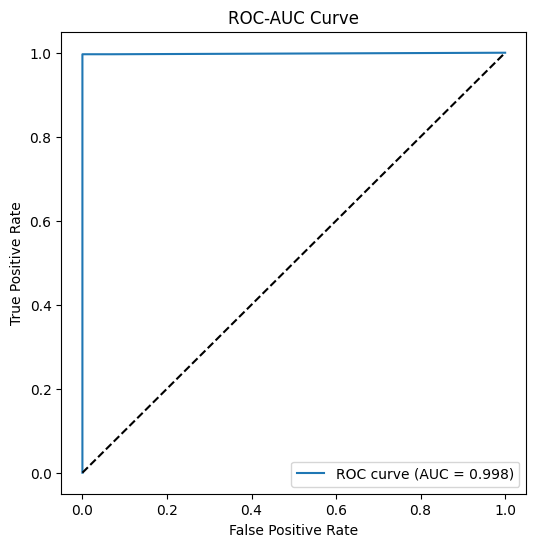

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      1.00      1.00       275

    accuracy                           1.00       550
   macro avg       1.00      1.00      1.00       550
weighted avg       1.00      1.00      1.00       550



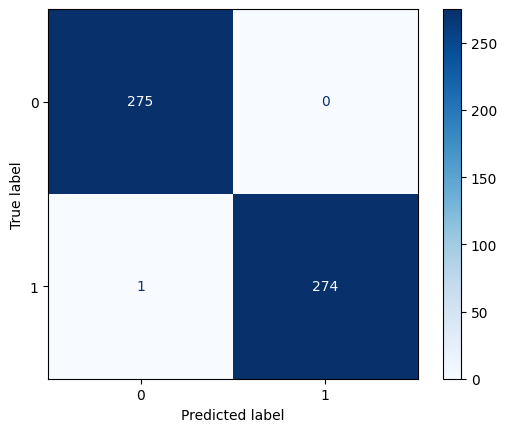

(np.float64(0.9980561983471073),
 array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
     

In [181]:
evaluate_model(results[best_params]['model'], X_test_final, y_test)

In [183]:
xgb_pipeline = Pipeline([
    ("xgb", XGBClassifier(
        max_depth=2,
        n_estimators=30,
        random_state=42
    ))
])

In [184]:
xgb_pipeline.fit(X_train_without_tfidf, y_train)


Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=30, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [185]:
preds = xgb_pipeline.predict(X_test_without_tfidf)
probs = xgb_pipeline.predict_proba(X_test_without_tfidf)[:, 1]


In [186]:
joblib.dump(xgb_pipeline, "xgb_essay_numeric_pipeline.joblib")


['xgb_essay_numeric_pipeline.joblib']

In [187]:
from google.colab import files
files.download("xgb_essay_numeric_pipeline.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [188]:
X_train_without_tfidf.head()

,punct_ratio,avg_token_length,type_token_ratio,hapax_legomena_ratio,pos_noun_ratio,pos_punct_ratio,pos_det_ratio,pos_adj_ratio,pos_adv_ratio,pos_verb_ratio,pos_pron_ratio,sentence_token_entropy
66,0.152597,5.733766,0.581169,0.415584,0.321429,0.152597,0.081169,0.152597,0.038961,0.120130,0.042208,0.812785
1136,0.103659,4.756098,0.573171,0.375000,0.283537,0.103659,0.091463,0.073171,0.036585,0.134146,0.045732,0.835505
1448,0.075294,4.654118,0.505882,0.343529,0.195294,0.075294,0.103529,0.087059,0.030588,0.129412,0.082353,0.805984
25,0.184211,5.710526,0.842105,0.710526,0.263158,0.184211,0.105263,0.131579,0.026316,0.078947,0.000000,0.921056
2434,0.071429,6.214286,1.000000,1.000000,0.357143,0.071429,0.142857,0.214286,0.000000,0.142857,0.000000,1.000000
